<a href="https://colab.research.google.com/github/18ivan18/CLEF2022-CheckThat/blob/main/CLEF2022Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
!pip install transformers -q

import transformers
from transformers import BertModel, BertTokenizerFast # base bert
from transformers import AutoModel, AutoTokenizer  # bertweet
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaTokenizerFast  # roberta


import torch
import torch.nn as nn
from tqdm import tqdm

import pandas as pd

import numpy as np

In [152]:
use_cuda=torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
device

'cuda'

# [CLEF2022-CheckThat!](https://sites.google.com/view/clef2022-checkthat/home)
## [Task 1: Identifying Relevant Claims in Tweets](https://sites.google.com/view/clef2022-checkthat/tasks/task-1-identifying-relevant-claims-in-tweets)

**Subtask 1A:** Check-worthiness of tweets: Given a tweet, predict whether it is worth fact-checking. This task is defined with binary labels: Yes and No.. This is a classification task. This subtasks runs in 6 languages:

- Arabic
- Bulgarian
- Dutch
- English
- Spanish
- Turkish

In this task I'll focus on English and Bulgarian only throughout all subtasks. English as the most popular language and presumably the models are best fitted for it, and Bulgarian as my native language.  

## First let's download the data and run the baseline.


In [115]:
!git clone https://gitlab.com/checkthat_lab/clef2022-checkthat-lab/clef2022-checkthat-lab.git

fatal: destination path 'clef2022-checkthat-lab' already exists and is not an empty directory.


In [153]:
import zipfile

data_directory_name="data/"
# Unzip target file
def unzip(filename):
  with zipfile.ZipFile(filename, mode="r") as archive:
     archive.extractall(data_directory_name)

def prepare_data(lang, subtask, subtask_id):
  unzip(f'/content/clef2022-checkthat-lab/task1/data/subtasks-{lang}/test/CT22_{lang}_{subtask_id}_{subtask}_test.zip')
  unzip(f'/content/clef2022-checkthat-lab/task1/data/subtasks-{lang}/CT22_{lang}_{subtask_id}_{subtask}.zip')
  unzip(f'/content/clef2022-checkthat-lab/task1/data/subtasks-{lang}/test/CT22_{lang}_{subtask_id}_{subtask}_test_gold.zip')
  
  df_train = pd.read_csv(f'/content/data/CT22_{lang}_{subtask_id}_{subtask}_train.tsv', sep='\t')
  df_train = pd.DataFrame({
        'text' : df_train['tweet_text'],
        'label' : df_train['class_label']
  })

  df_valid = pd.read_csv(f'/content/data/CT22_{lang}_{subtask_id}_{subtask}_dev.tsv', sep='\t')
  df_valid = pd.DataFrame({
      'text' : df_valid['tweet_text'],
      'label' : df_valid['class_label']
  })

  df_test = pd.read_csv(f'/content/data/CT22_{lang}_{subtask_id}_{subtask}_test.tsv', sep='\t')
  return df_train, df_valid, df_test


In [154]:
lang='english'
subtask='checkworthy'
subtask_id='1A'
results_fpath=f'data/subtask{subtask_id}_{subtask}_{lang}.tsv'
run_id='izarabadzh'

In [155]:
from collections import defaultdict

df_train, df_valid, df_test = prepare_data(lang, subtask, subtask_id)

def encode_labels(labels):
  i = 0
  labels_dict = defaultdict()
  for label in labels.unique():
      labels_dict[label] = i
      i += 1
  return labels_dict
    
encode_labels(df_train['label'])

defaultdict(None, {0: 0, 1: 1})

In [156]:
def inverse_dict(dict):
  return {v: k for k, v in dict.items()}
inverse_dict(encode_labels(df_train['label']))

{0: 0, 1: 1}

In [157]:
df_train.head()

,text,label
0,"India's gift of 100,000 COVID-19 vaccines arri...",0
1,As part of the ongoing nationwide vaccination ...,0
2,"Pleased to receive 50,000 doses of Covid-19 va...",0
3,Four former presidents have banded together fo...,0
4,WSJ: All three of Russia's main intelligence s...,1


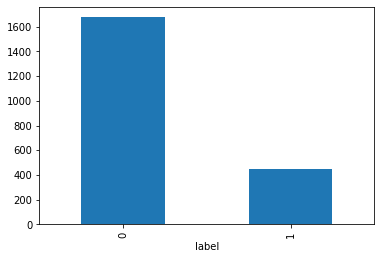

In [158]:
df_train.groupby(['label']).size().plot.bar()

In [159]:
df_valid.head()

,text,label
0,Native American communities have been hit hard...,0
1,ALERT: CVS Pharmacy is now offering COVID-19 v...,0
2,#COVID19 vaccines are an important tool to hel...,0
3,Pfizer reports that IRL the vaccine is 97% eff...,0
4,Vaccines are complex medicines. Europeans can ...,0


## Baseline.
Here we just use the script provided by the creators of CLEF.

```
#python -t /home/bjit/Nandi-AI/NLP/clef2022-checkthat-lab/task1/data/subtasks-english/CT22_english_1B_claim/CT22_english_1B_claim_train.tsv -d /home/bjit/Nandi-AI/NLP/clef2022-checkthat-lab/task1/data/subtasks-english/CT22_english_1B_claim/CT22_english_1B_claim_dev.tsv -l english -a claim
```

Majority Baseline for Subtask-checkworthy--english F1 (positive class): 0.0

Random Baseline for Subtask-checkworthy--english F1 (positive class): 0.23376623376623376  

Ngram Baseline for Subtask-checkworthy--english F1 (positive class): 0.34615384615384615

In [160]:
# train data
df_train['label'].shape

(2122,)

In [194]:
from enum import Enum

class ModelName(Enum):
     BERT = 'Bert'
     BERTWEET = 'Bertweet'
     ROBERTA = 'Roberta'

class Language(Enum):
     BULGARIAN = 'bulgarian'
     ENGLISH = 'english'
     SPANISH = 'spanish'
     TURKISH = 'turkish'
     DUTCH = 'dutch'
     ARABIC = 'arabic'
     
     
model_name: ModelName = ModelName.BERT
language_name: Language = Language.ENGLISH

In [187]:
"""This contains various tokenizer, uncomment and use the tokenizer as per the model requirement"""

def get_tokenizer(model_name: ModelName):
  if model_name==ModelName.BERT:
    if language_name==Language.ENGLISH:
      return BertTokenizer.from_pretrained("bert-base-cased")
    else:
      return BertTokenizer.from_pretrained("bert-base-multilingual-cased")
  if model_name==ModelName.BERTWEET:
    return AutoTokenizer.from_pretrained("vinai/bertweet-base")
  if model_name==ModelName.ROBERTA:
    return RobertaTokenizerFast.from_pretrained("roberta-base")

tokenizer=get_tokenizer(model_name)
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [164]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        labels = encode_labels(df['label'])
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length=512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [165]:
class BertClassifier(nn.Module):

    def __init__(self, transformer, dropout=0.5, target=2):

        super(BertClassifier, self).__init__()

        self.transformer = transformer
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, target)
        self.relu = nn.ReLU()


    def forward(self, input_id, mask):

        _, pooled_output = self.transformer(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [166]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [188]:
def get_transformer(model_name: ModelName):
  if model_name==ModelName.BERT:
    if language_name==Language.ENGLISH:
      return BertModel.from_pretrained("bert-base-cased")
    else:
      return BertModel.from_pretrained("bert-base-multilingual-cased")
  if model_name==ModelName.BERTWEET:
    return AutoModel.from_pretrained("vinai/bertweet-base")
  if model_name==ModelName.ROBERTA:
    return RobertaModel.from_pretrained("roberta-base")

transformer=get_transformer(model_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [168]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [169]:
model_1A=BertClassifier(transformer)
print(f'The model has {count_parameters(model_1A):,} trainable parameters')


The model has 108,311,810 trainable parameters


In [195]:
LR=1e-6 
EPOCHS=15

In [171]:
for name, param in model_1A.named_parameters():
  if "pooler" in name or "linear" in name: 
    param.requires_grad = True
  else:
    param.requires_grad = False
  print(name, param.shape, param.requires_grad)

print(f'The model has {count_parameters(model_1A):,} trainable parameters')

transformer.embeddings.word_embeddings.weight torch.Size([28996, 768]) False
transformer.embeddings.position_embeddings.weight torch.Size([512, 768]) False
transformer.embeddings.token_type_embeddings.weight torch.Size([2, 768]) False
transformer.embeddings.LayerNorm.weight torch.Size([768]) False
transformer.embeddings.LayerNorm.bias torch.Size([768]) False
transformer.encoder.layer.0.attention.self.query.weight torch.Size([768, 768]) False
transformer.encoder.layer.0.attention.self.query.bias torch.Size([768]) False
transformer.encoder.layer.0.attention.self.key.weight torch.Size([768, 768]) False
transformer.encoder.layer.0.attention.self.key.bias torch.Size([768]) False
transformer.encoder.layer.0.attention.self.value.weight torch.Size([768, 768]) False
transformer.encoder.layer.0.attention.self.value.bias torch.Size([768]) False
transformer.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768]) False
transformer.encoder.layer.0.attention.output.dense.bias torch.Size(

In [172]:
# train(model_1A, df_train, df_valid, LR, EPOCHS)

# torch.save(model_1A.state_dict(), f"model_{lang}_{subtask}_{subtask_id}_{EPOCHS}_epochs.bin")
 

100%|██████████| 1061/1061 [01:13<00:00, 14.37it/s]


Epochs: 1 | Train Loss:  0.288 | Train Accuracy:  0.766 | Val Loss:  0.276 | Val Accuracy:  0.769


100%|██████████| 1061/1061 [01:13<00:00, 14.41it/s]


Epochs: 2 | Train Loss:  0.268 | Train Accuracy:  0.786 | Val Loss:  0.282 | Val Accuracy:  0.769


100%|██████████| 1061/1061 [01:14<00:00, 14.24it/s]


Epochs: 3 | Train Loss:  0.268 | Train Accuracy:  0.790 | Val Loss:  0.268 | Val Accuracy:  0.774


100%|██████████| 1061/1061 [01:15<00:00, 14.10it/s]


Epochs: 4 | Train Loss:  0.259 | Train Accuracy:  0.788 | Val Loss:  0.273 | Val Accuracy:  0.774


100%|██████████| 1061/1061 [01:15<00:00, 14.05it/s]


Epochs: 5 | Train Loss:  0.262 | Train Accuracy:  0.788 | Val Loss:  0.271 | Val Accuracy:  0.774


In [173]:
df_test.head()


,topic,tweet_id,tweet_url,tweet_text
0,COVID-19,1425267281202909184,http://twitter.com/user/status/142526728120290...,i was a vaccine checker tonight at my venue an...
1,COVID-19,1387113304959504384,http://twitter.com/user/status/138711330495950...,I asked the nurse giving my vaccine if I could...
2,COVID-19,1379498353294069760,http://twitter.com/user/status/137949835329406...,When the polio vaccine dropped in 1955 people ...
3,COVID-19,1369843850223759362,http://twitter.com/user/status/136984385022375...,I asked my mom if she felt any side effects fr...
4,COVID-19,1352425395375759363,http://twitter.com/user/status/135242539537575...,A 6-year old ballet student asked me today if ...


# Predicting
Go through the test set one by one and predict the values. Write to an output file.

In [174]:
def predict(model, test_data, mapping=lambda x: x):

    test_data['test_input'] = [tokenizer(text, padding='max_length', max_length=512, truncation=True,
                                return_tensors="pt") for text in test_data['tweet_text']]

    model = model.to(device)

    with torch.no_grad():
        with open(results_fpath, "w") as results_file:
          results_file.write("topic\ttweet_id\tclass_label\trun_id\n") 
          for topic, tweet_id, _, _, test_input in test_data.values:

                mask = test_input['attention_mask'].to(device)
                input_id = test_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask).argmax(dim=1)[0].item()
                results_file.write(f'{topic}\t{tweet_id}\t{mapping(output)}\t{run_id}\n')

In [175]:
# predict(model_1A, df_test)

# Evaluation
All of the code below is provided by the creators of CLEF for scoring.

In [176]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import re
_LINE_PATTERN_A = re.compile('^[1-9][0-9]{16,22}\t([-+]?\d*\.\d+|\d+)$')

def check_format(file_path):
    with open(file_path, encoding='UTF-8') as out:
        next(out)
        file_content = out.read().strip()
        for i, line in enumerate(file_content.split('\n')):
            topic_id, tweet_id, score, run_id = line.strip().split('\t')

            if not _LINE_PATTERN_A.match("%s\t%s"%(tweet_id, score)):
                # 1. Check line format.
                logging.error(f"Wrong line format: {line}")
                return False
            tweet_id = int(tweet_id)
            score = float(score.strip())

    return True


import logging

def _read_gold_and_pred(gold_fpath, pred_fpath):
    """
    Read gold and predicted data.
    :param gold_fpath: the original annotated gold file, where the last 4th column contains the labels.
    :param pred_fpath: a file with line_number and score at each line.
    :return: {line_number:label} dict; list with (line_number, score) tuples.
    """

    logging.info("Reading gold labels from file {}".format(gold_fpath))

    gold_labels = {}
    with open(gold_fpath, encoding='utf-8') as gold_f:
        next(gold_f)
        for line_res in gold_f:
            (topic_id, tweet_id, tweet_url, tweet_text, check_worthiness) = line_res.strip().split('\t')  # process the line from the res file
            if topic_id == 'topic':
                continue
            label = check_worthiness
            gold_labels[str(tweet_id)] = label

    logging.info('Reading predicted labels from file {}'.format(pred_fpath))

    line_score = []
    # labels=[]
    with open(pred_fpath) as pred_f:
        next(pred_f)
        for line in pred_f:
            topic_id, tweet_id, score, run_id  = line.split('\t')
            tweet_id = str(tweet_id.strip())
            # score = float(score.strip())
            score = score.strip()

            if tweet_id not in gold_labels:
                logging.error('No such tweet_id: {} in gold file!'.format(tweet_id))
                quit()
            line_score.append((tweet_id, score))
            # labels.append(score)


    if len(set(gold_labels).difference([tup[0] for tup in line_score])) != 0:
        logging.error('The predictions do not match the lines from the gold file - missing or extra line_no')
        raise ValueError('The predictions do not match the lines from the gold file - missing or extra line_no')

    return gold_labels, line_score

def evaluate(gold_fpath, pred_fpath, subtask="checkworthy"):
    """
    Evaluates the predicted line rankings w.r.t. a gold file.
    Metrics are: Average Precision, R-Pr, Reciprocal Rank, Precision@N
    :param gold_fpath: the original annotated gold file, where the last 4th column contains the labels.
    :param pred_fpath: a file with line_number at each line, where the list is ordered by check-worthiness.
    :param thresholds: thresholds used for Reciprocal Rank@N and Precision@N.
    If not specified - 1, 3, 5, 10, 20, 50, len(ranked_lines).
    """
    gold_labels_dict, pred_labels_dict = _read_gold_and_pred(gold_fpath, pred_fpath)
    gold_labels=[]
    pred_labels=[]
    for t_id, label in gold_labels_dict.items():
        gold_labels.append(label)
    for t_id, label in pred_labels_dict:
        pred_labels.append(label)
    # ranked_lines = [t[0] for t in sorted(line_score, key=lambda x: x[1], reverse=True)]
    # if thresholds is None or len(thresholds) == 0:
    #     thresholds = MAIN_THRESHOLDS + [len(ranked_lines)]

    # Calculate Metrics
    # precisions = _compute_precisions(gold_labels, ranked_lines, len(ranked_lines))
    # precision = _compute_average_precision(gold_labels, pred_labels)
    # reciprocal_rank = _compute_reciprocal_rank(gold_labels, ranked_lines)
    # num_relevant = len({k for k, v in gold_labels.items() if v == 1})
    if(subtask == "checkworthy" or subtask == "harmful"):
        acc = accuracy_score(gold_labels, pred_labels)
        precision = precision_score(gold_labels, pred_labels, pos_label='1',average='binary')
        recall = recall_score(gold_labels, pred_labels, pos_label='1',average='binary')
        f1=f1_score(gold_labels, pred_labels, pos_label='1',average='binary')
    elif(subtask == "attentionworthy"):
        acc = accuracy_score(gold_labels, pred_labels)
        precision = precision_score(gold_labels, pred_labels, average = 'weighted')
        recall = recall_score(gold_labels, pred_labels, average = 'weighted')
        f1 = f1_score(gold_labels, pred_labels, average = 'weighted')
    elif (subtask == "claim"):
        acc=accuracy_score(gold_labels, pred_labels)
        precision = precision_score(gold_labels, pred_labels, average = 'weighted')
        recall = recall_score(gold_labels, pred_labels, average = 'weighted')
        f1 = f1_score(gold_labels, pred_labels, average = 'weighted')

    return acc, precision, recall, f1


def validate_files(pred_file, subtask):
    if not check_format(pred_file):
        logging.error('Bad format for pred file {}. Cannot score.'.format(pred_file))
        return False
    return True

line_separator = '=' * 120

MAIN_THRESHOLDS = [1, 3, 5, 10, 20, 50]

def score(pred_file, gold_file, subtask):
  if validate_files(pred_file, subtask):
    acc, precision, recall, f1 = evaluate(gold_file, pred_file, subtask=subtask)
    print("acc: {}, P:{}, R:{}, F1:{}".format(acc, precision, recall, f1))

In [ ]:
gold_file = f'/content/data/CT22_{lang}_{subtask_id}_{subtask}_test_gold.tsv'

# score(results_fpath, gold_file, subtask)

In [ ]:
lang='bulgarian'
subtask='checkworthy'
subtask_id='1A'
results_fpath=f'/content/data/subtask{subtask_id}_{subtask}_{lang}.tsv'

df_train, df_valid, df_test = prepare_data(lang, subtask, subtask_id)

transformer=get_transformer(model_name)
model_1A_bulgarian = BertClassifier(transformer)
              
train(model_1A_bulgarian, df_train, df_valid, LR, EPOCHS)

torch.save(model_1A_bulgarian.state_dict(), f"model_{lang}_{subtask}_{subtask_id}_{EPOCHS}_epochs.bin")

predict(model_1A_bulgarian, df_test)

gold_file = f'/content/data/CT22_{lang}_{subtask_id}_{subtask}_test_gold.tsv'

score(results_fpath, gold_file, subtask)

In [ ]:
lang='english'
subtask='checkworthy'
subtask_id='1A'
results_fpath=f'/content/data/subtask{subtask_id}_{subtask}_{lang}.tsv'

df_train, df_valid, df_test = prepare_data(lang, subtask, subtask_id)

transformer=get_transformer(model_name)
model_1A = BertClassifier(transformer)
              
train(model_1A, df_train, df_valid, LR, EPOCHS)

torch.save(model_1A.state_dict(), f"model_{lang}_{subtask}_{subtask_id}_{EPOCHS}_epochs.bin")

predict(model_1A, df_test)

gold_file = f'/content/data/CT22_{lang}_{subtask_id}_{subtask}_test_gold.tsv'

score(results_fpath, gold_file, subtask)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1061/1061 [03:49<00:00,  4.62it/s]


Epochs: 1 | Train Loss:  0.275 | Train Accuracy:  0.758 | Val Loss:  0.277 | Val Accuracy:  0.774


100%|██████████| 1061/1061 [03:49<00:00,  4.62it/s]


Epochs: 2 | Train Loss:  0.251 | Train Accuracy:  0.789 | Val Loss:  0.267 | Val Accuracy:  0.774


100%|██████████| 1061/1061 [03:49<00:00,  4.62it/s]


Epochs: 3 | Train Loss:  0.221 | Train Accuracy:  0.787 | Val Loss:  0.233 | Val Accuracy:  0.779


 71%|███████   | 753/1061 [02:42<01:06,  4.60it/s]

**Subtask 1B:** Verifiable factual claims detection: Given a tweet, predict whether it contains a verifiable factual claim. This is a binary task with two labels: Yes and No. This is a classification task. This subtasks runs in 5 languages:

- Arabic
- Bulgarian
- Dutch
- English
- Turkish

In [193]:
lang='english'
subtask='claim'
subtask_id='1B'
results_fpath=f'/content/data/subtask{subtask_id}_{subtask}_{lang}.tsv'

df_train, df_valid, df_test = prepare_data(lang, subtask, subtask_id)

transformer=get_transformer(model_name)
model_1B = BertClassifier(transformer)
              
train(model_1B, df_train, df_valid, LR, EPOCHS)

torch.save(model_1B.state_dict(), f"model_{lang}_{subtask}_{subtask_id}_{EPOCHS}_epochs.bin")

predict(model_1B, df_test)

gold_file = f'/content/data/CT22_{lang}_{subtask_id}_{subtask}_test_gold.tsv'

score(results_fpath, gold_file, subtask)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1662/1662 [06:09<00:00,  4.50it/s]


Epochs: 1 | Train Loss:  0.328 | Train Accuracy:  0.640 | Val Loss:  0.329 | Val Accuracy:  0.635


100%|██████████| 1662/1662 [06:09<00:00,  4.50it/s]


Epochs: 2 | Train Loss:  0.319 | Train Accuracy:  0.638 | Val Loss:  0.315 | Val Accuracy:  0.638


100%|██████████| 1662/1662 [06:08<00:00,  4.51it/s]


Epochs: 3 | Train Loss:  0.293 | Train Accuracy:  0.660 | Val Loss:  0.327 | Val Accuracy:  0.645


100%|██████████| 1662/1662 [06:08<00:00,  4.51it/s]


Epochs: 4 | Train Loss:  0.251 | Train Accuracy:  0.749 | Val Loss:  0.325 | Val Accuracy:  0.629


100%|██████████| 1662/1662 [06:08<00:00,  4.51it/s]


Epochs: 5 | Train Loss:  0.198 | Train Accuracy:  0.822 | Val Loss:  0.369 | Val Accuracy:  0.622
acc: 0.3784860557768924, P:0.40506103440120794, R:0.3784860557768924, F1:0.37978844085178215


**Subtask 1C:** Harmful tweet detection : Given a tweet, predict whether it is harmful to the society and why. This task is defined with binary labels: Yes and No. This is a classification task. This subtasks runs in 5 languages:

- Arabic
- Bulgarian
- Dutch
- English
- Turkish

In [186]:
lang='english'
subtask='harmful'
subtask_id='1C'
results_fpath=f'/content/data/subtask{subtask_id}_{subtask}_{lang}.tsv'

df_train, df_valid, df_test = prepare_data(lang, subtask, subtask_id)

transformer = get_transformer(model_name)
model_1C = BertClassifier(transformer)
              
train(model_1C, df_train, df_valid, LR, EPOCHS)

torch.save(model_1C.state_dict(), f"model_{lang}_{subtask}_{subtask_id}_{EPOCHS}_epochs.bin")

predict(model_1C, df_test)

gold_file = f'/content/data/CT22_{lang}_{subtask_id}_{subtask}_test_gold.tsv'

score(results_fpath, gold_file, subtask)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1662/1662 [05:49<00:00,  4.75it/s]


Epochs: 1 | Train Loss:  0.177 | Train Accuracy:  0.896 | Val Loss:  0.159 | Val Accuracy:  0.899


100%|██████████| 1662/1662 [05:58<00:00,  4.63it/s]


Epochs: 2 | Train Loss:  0.139 | Train Accuracy:  0.912 | Val Loss:  0.139 | Val Accuracy:  0.899


100%|██████████| 1662/1662 [05:58<00:00,  4.64it/s]


Epochs: 3 | Train Loss:  0.115 | Train Accuracy:  0.912 | Val Loss:  0.144 | Val Accuracy:  0.899


100%|██████████| 1662/1662 [05:57<00:00,  4.65it/s]


Epochs: 4 | Train Loss:  0.093 | Train Accuracy:  0.914 | Val Loss:  0.135 | Val Accuracy:  0.899


100%|██████████| 1662/1662 [05:56<00:00,  4.66it/s]


Epochs: 5 | Train Loss:  0.073 | Train Accuracy:  0.914 | Val Loss:  0.136 | Val Accuracy:  0.899


100%|██████████| 1662/1662 [05:58<00:00,  4.63it/s]


Epochs: 6 | Train Loss:  0.058 | Train Accuracy:  0.915 | Val Loss:  0.140 | Val Accuracy:  0.899


100%|██████████| 1662/1662 [05:58<00:00,  4.63it/s]


Epochs: 7 | Train Loss:  0.048 | Train Accuracy:  0.919 | Val Loss:  0.198 | Val Accuracy:  0.899


100%|██████████| 1662/1662 [05:57<00:00,  4.65it/s]


Epochs: 8 | Train Loss:  0.043 | Train Accuracy:  0.924 | Val Loss:  0.139 | Val Accuracy:  0.912


100%|██████████| 1662/1662 [05:57<00:00,  4.65it/s]


Epochs: 9 | Train Loss:  0.039 | Train Accuracy:  0.925 | Val Loss:  0.146 | Val Accuracy:  0.902


100%|██████████| 1662/1662 [05:59<00:00,  4.62it/s]


Epochs: 10 | Train Loss:  0.035 | Train Accuracy:  0.933 | Val Loss:  0.173 | Val Accuracy:  0.909
acc: 0.8286852589641435, P:0.4, R:0.15, F1:0.21818181818181814


**Subtask 1D:** Attention-worthy tweet detection: Given a tweet, predict whether it should get the attention of policy makers and why. This task is defined with nine class labels: (i) No, not interesting, (ii) Yes, asks question, (iii) Yes, blame authorities, (iv) Yes, calls for action, (v) Yes, classified as in harmful task, (vi) Yes, contains advice, (vii) Yes, discusses action taken, (viii) Yes, discusses cure, and (ix) Yes, other. This is a classification task. This subtasks runs in 5 languages:

- Arabic
- Bulgarian
- Dutch
- English
- Turkish

In [179]:
lang='english'
subtask='attentionworthy'
subtask_id='1D'
results_fpath=f'/content/data/subtask{subtask_id}_{subtask}_{lang}.tsv'

df_train, df_valid, df_test = prepare_data(lang, subtask, subtask_id)

labels=encode_labels(df_train['label'])
output_to_label=inverse_dict(labels)

transformer = get_transformer(model_name)
model_1D = BertClassifier(transformer, target=len(labels))
              
train(model_1D, df_train, df_valid, LR, EPOCHS)

torch.save(model_1D.state_dict(), f"model_{lang}_{subtask}_{subtask_id}_{EPOCHS}_epochs.bin")

predict(model_1D, df_test, lambda x: output_to_label[x])

gold_file = f'/content/data/CT22_{lang}_{subtask_id}_{subtask}_test_gold.tsv'

score(results_fpath, gold_file, subtask)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1661/1661 [05:53<00:00,  4.70it/s]


Epochs: 1 | Train Loss:  0.442 | Train Accuracy:  0.806 | Val Loss:  0.294 | Val Accuracy:  0.873


100%|██████████| 1661/1661 [05:58<00:00,  4.63it/s]


Epochs: 2 | Train Loss:  0.328 | Train Accuracy:  0.859 | Val Loss:  0.285 | Val Accuracy:  0.873


100%|██████████| 1661/1661 [05:57<00:00,  4.65it/s]


Epochs: 3 | Train Loss:  0.297 | Train Accuracy:  0.859 | Val Loss:  0.297 | Val Accuracy:  0.873


100%|██████████| 1661/1661 [05:57<00:00,  4.65it/s]


Epochs: 4 | Train Loss:  0.264 | Train Accuracy:  0.859 | Val Loss:  0.256 | Val Accuracy:  0.873


100%|██████████| 1661/1661 [05:58<00:00,  4.64it/s]


Epochs: 5 | Train Loss:  0.235 | Train Accuracy:  0.865 | Val Loss:  0.262 | Val Accuracy:  0.853


ERROR:root:Wrong line format: COVID-19	1333505660407963648	no_not_interesting	izarabadzh
ERROR:root:Bad format for pred file /content/data/subtask1D_attentionworthy_english.tsv. Cannot score.


In [ ]:
!pip freeze > requirement.txt